<ipython-input-18-0d23fa61582a>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


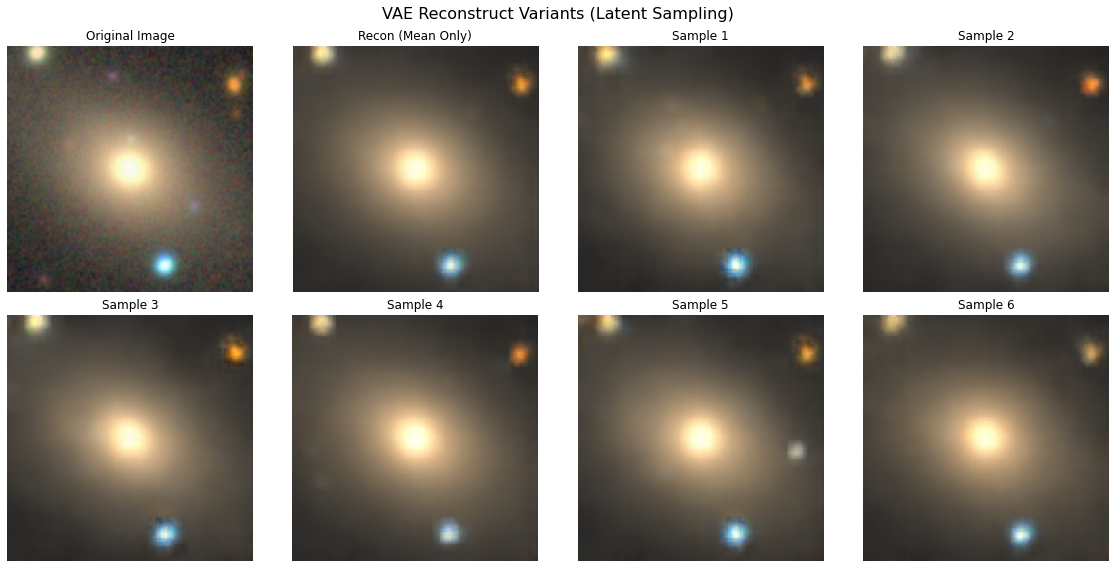

✅ Reconstruction sampling variants saved to ./results/reconstruction_sampling_variants.png


In [18]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import glob

# 参数配置
MODEL_PATH = "./models/vae_final.pth"
IMAGE_PATHS = glob.glob("/home/amax/ljm/DATA/Desi_galaxyzoo2_fits/DATA/DATAdesi/jpg/1/*.jpg")
if not IMAGE_PATHS:
    raise FileNotFoundError("No JPG images found in the data path.")
IMAGE_PATH = IMAGE_PATHS[3]
RESULT_PATH = "./results/single_recon.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 图像转换操作
transform = transforms.Compose([
    transforms.CenterCrop(152),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 加载模型
from model import VAE  # 确保导入你的Autoencoder类
model = VAE(latent_dim=128).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()


# 加载并预处理图像
image = Image.open(IMAGE_PATH).convert('RGB')
x = transform(image).unsqueeze(0).to(device)

# 参数设置
# -------------------------------
NUM_SAMPLES = 6        # 每张图生成 6 个不同采样结果
RESULT_PATH = "./results/reconstruction_sampling_variants.png"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 假设 x 是一个 batch 的数据 (x.shape: [B, C, H, W])
# 这里我们只取第一张图像做演示
x = x.to(device)  # 确保在正确设备上

# -------------------------------
# 推理：获取 mu 和 log_var
# -------------------------------
with torch.no_grad():
    # 假设 model(x) 返回 recon_x, z, mu, log_var
    _, _, mu, log_var = model(x)  # 只需要 mu 和 log_var

    # 提取第一张图像的编码分布
    mu_0 = mu[0:1]        # shape: (1, 128)
    log_var_0 = log_var[0:1]
    std_0 = torch.exp(0.5 * log_var_0)

    # 先生成“均值重建”（不加噪声，确定性输出）
    z_mean = mu_0  # z = mu + 0*std
    recon_mean = model.decode(z_mean).clamp(0, 1)

    # 存储多次随机采样的重建结果
    reconstructions = []
    for i in range(NUM_SAMPLES):
        eps = torch.randn_like(std_0)           # 随机噪声
        z_sample = mu_0 + eps * std_0           # 重参数化
        recon_x = model.decode(z_sample)        # 解码
        recon_x = recon_x.clamp(0, 1)           # 截断到 [0,1]
        reconstructions.append(recon_x[0].cpu())  # 保存为 CPU tensor

# -------------------------------
# 可视化：原始 + 均值重建 + 多次采样
# -------------------------------
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# 原始图像
orig_img = x[0].cpu().permute(1, 2, 0).numpy()
axes[0].imshow(orig_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# 均值重建（无噪声）
mean_img = recon_mean[0].cpu().permute(1, 2, 0).numpy()
axes[1].imshow(mean_img)
axes[1].set_title("Recon (Mean Only)")
axes[1].axis('off')

# 多次随机采样重建
for i, recon in enumerate(reconstructions):
    img = recon.permute(1, 2, 0).numpy()
    axes[i+2].imshow(img)
    axes[i+2].set_title(f"Sample {i+1}")
    axes[i+2].axis('off')

# 如果不够 8 个 subplot，隐藏多余的
for j in range(len(reconstructions)+2, len(axes)):
    axes[j].axis('off')

plt.suptitle(f"VAE Reconstruct Variants (Latent Sampling)", fontsize=16)
plt.tight_layout()
plt.savefig(RESULT_PATH, bbox_inches='tight', dpi=150)
plt.show()

print(f"✅ Reconstruction sampling variants saved to {RESULT_PATH}")

Extracting latent representations from VAE (using mu)...


<ipython-input-19-08c55e6a5759>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Latent features shape: (3000, 128)
Performing dimensionality reduction...
Reduced to 2D using t-SNE


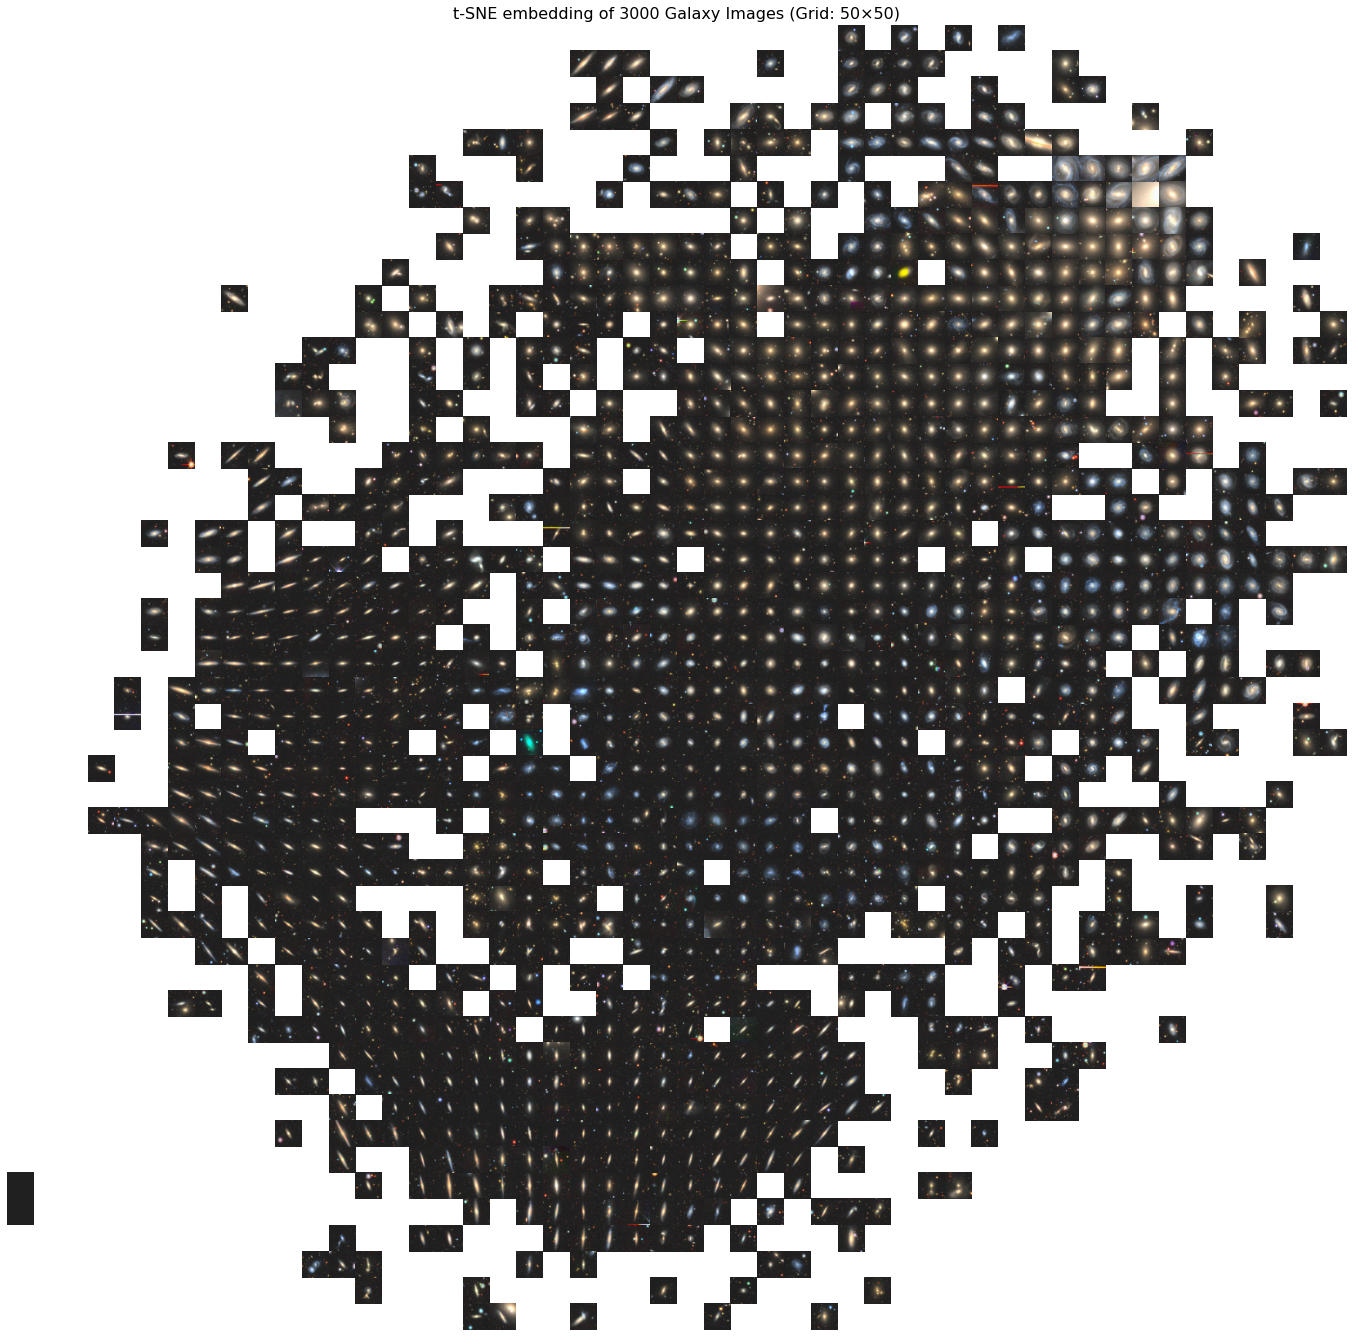

✅ 图像网格图保存到: ./results/latent_t-sne_images_50x50.png


<ipython-input-19-08c55e6a5759>:156: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, alpha=0.8, cmap='viridis')


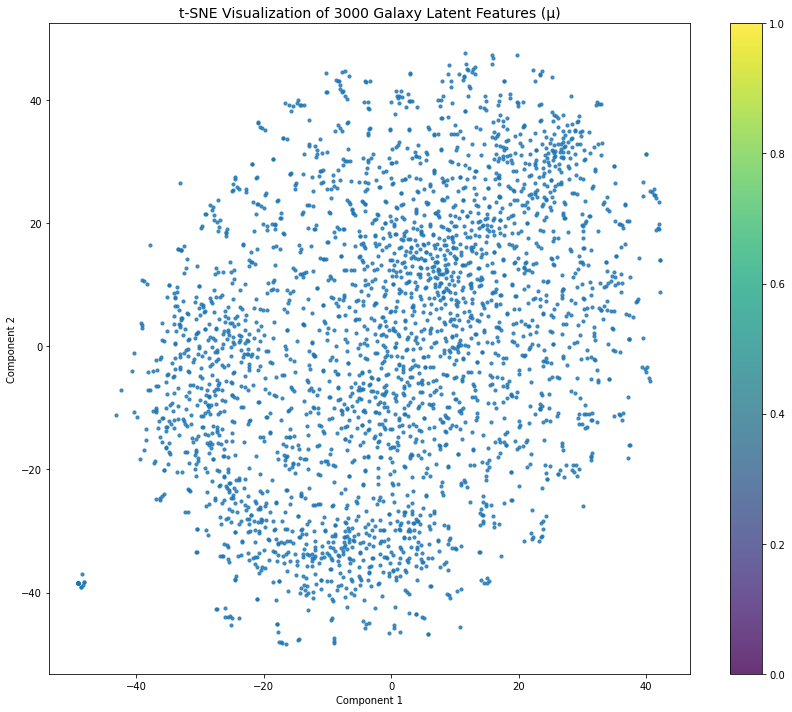

✅ 散点图保存到: ./results/latent_t-sne_scatter.png


In [19]:
# visualize_vae_latent.py
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import glob
import os
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader

# 注意：导入的是 VAE 模型
from model import VAE  # 确保你已定义 VAE 类

# -------------------------------
# 参数设置
# -------------------------------
MODEL_PATH = "./models/vae_final.pth"
IMAGE_DIR = "/home/amax/ljm/DATA/Desi_galaxyzoo2_fits/DATA/DATAdesi/jpg/1"
RESULT_DIR = "./results"
os.makedirs(RESULT_DIR, exist_ok=True)

RESULT_PLOT_PATH = os.path.join(RESULT_DIR, "tsne_latent_3000.png")
NUM_SAMPLES = 3000
LATENT_DIM = 128
IMG_SIZE = 128
BATCH_SIZE = 64
USE_TSNE = True  # 可切换为 False 使用 PCA
DOWNSAMPLE_FIRST = True  # 无实际影响，保留

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 图像预处理（必须与训练一致）
transform = transforms.Compose([
    transforms.CenterCrop(152),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# -------------------------------
# 自定义 Dataset
# -------------------------------
class GalaxyDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, path  # 返回图像和路径

# -------------------------------
# 加载 VAE 模型
# -------------------------------
model = VAE(latent_dim=LATENT_DIM, img_channels=3, img_size=IMG_SIZE).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# -------------------------------
# 获取图像路径并随机采样
# -------------------------------
all_image_paths = glob.glob(os.path.join(IMAGE_DIR, "*.jpg"))
if len(all_image_paths) < NUM_SAMPLES:
    raise ValueError(f"Not enough images: found {len(all_image_paths)}, need {NUM_SAMPLES}")

np.random.seed(42)
selected_paths = np.random.choice(all_image_paths, size=NUM_SAMPLES, replace=False)

dataset = GalaxyDataset(selected_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# -------------------------------
# 提取潜在特征（使用 mu）
# -------------------------------
latents = []
filenames = []

print("Extracting latent representations from VAE (using mu)...")
with torch.no_grad():
    for x, names in dataloader:
        x = x.to(device)
        mu, log_var = model.encode(x)  # VAE 输出 mu 和 log_var
        latents.append(mu.cpu().numpy())  # 使用 mu 作为隐表示
        filenames.extend(names)

latents = np.concatenate(latents, axis=0)  # (NUM_SAMPLES, LATENT_DIM)
print(f"Latent features shape: {latents.shape}")

# -------------------------------
# 降维：t-SNE 或 PCA
# -------------------------------
print("Performing dimensionality reduction...")
if USE_TSNE:
    reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    method = "t-SNE"
else:
    reducer = PCA(n_components=2, random_state=42)
    method = "PCA"

latents_2d = reducer.fit_transform(latents)
print(f"Reduced to 2D using {method}")

# -------------------------------
# 可视化函数（散点图 + 图像网格）
# -------------------------------
def plot_latent_with_images(embeddings, filenames, grid_size=50, outdir="./results"):
    """
    在二维嵌入空间中绘制图像缩略图（类似 UMAP 图像墙）
    """
    os.makedirs(outdir, exist_ok=True)

    # 归一化坐标到 [0, grid_size]
    x_norm = (embeddings[:, 0] - embeddings[:, 0].min()) / (embeddings[:, 0].max() - embeddings[:, 0].min())
    y_norm = (embeddings[:, 1] - embeddings[:, 1].min()) / (embeddings[:, 1].max() - embeddings[:, 1].min())

    grid_x = (x_norm * grid_size).astype(int)
    grid_y = (y_norm * grid_size).astype(int)

    # 限制在网格范围内
    grid_x = np.clip(grid_x, 0, grid_size - 1)
    grid_y = np.clip(grid_y, 0, grid_size - 1)

    # 创建图像网格画布
    fig, ax = plt.subplots(figsize=(24, 24))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_title(f"{method} embedding of {len(filenames)} Galaxy Images (Grid: {grid_size}×{grid_size})", fontsize=16)
    ax.axis('off')

    # 每个网格只放一张图（避免重叠）
    placed = set()
    for i in range(len(filenames)):
        pos = (grid_x[i], grid_y[i])
        if pos not in placed:
            try:
                img = Image.open(filenames[i])
                ax.imshow(img, extent=(pos[0], pos[0]+1, pos[1], pos[1]+1), origin='upper', aspect='auto')
                placed.add(pos)
            except Exception as e:
                print(f"Failed to load image {filenames[i]}: {e}")

    img_grid_file = os.path.join(outdir, f"latent_{method.lower()}_images_{grid_size}x{grid_size}.png")
    plt.show()
    plt.close(fig)
    print(f"✅ 图像网格图保存到: {img_grid_file}")

    # 绘制纯散点图
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, alpha=0.8, cmap='viridis')
    plt.title(f"{method} Visualization of {NUM_SAMPLES} Galaxy Latent Features (μ)", fontsize=14)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(scatter)
    plt.tight_layout()
    scatter_plot_file = os.path.join(outdir, f"latent_{method.lower()}_scatter.png")
    plt.savefig(scatter_plot_file, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ 散点图保存到: {scatter_plot_file}")


# -------------------------------
# 执行可视化
# -------------------------------
plot_latent_with_images(latents_2d, filenames)

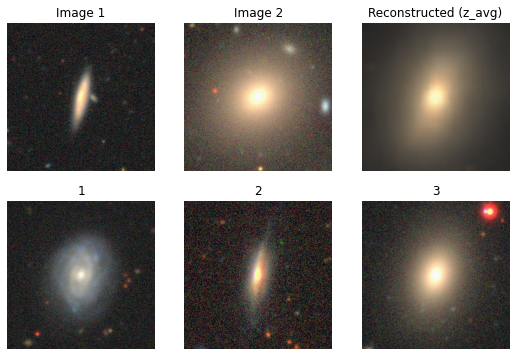

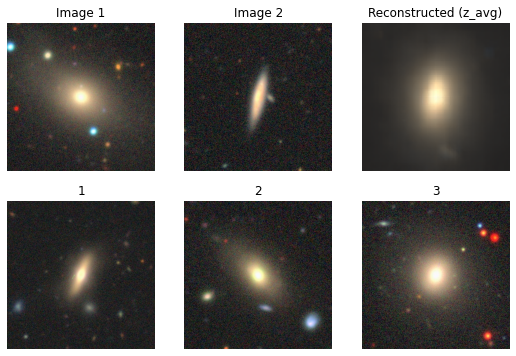

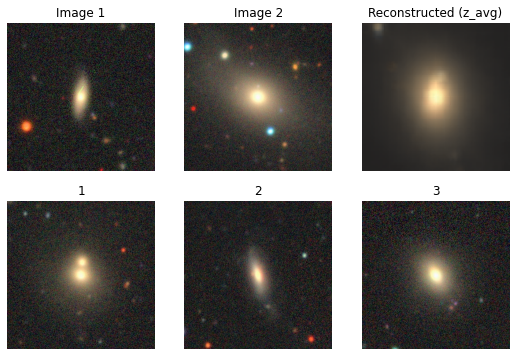

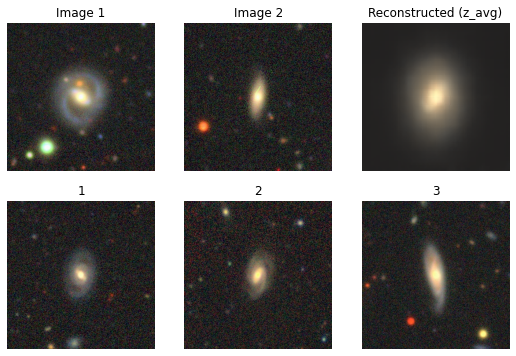

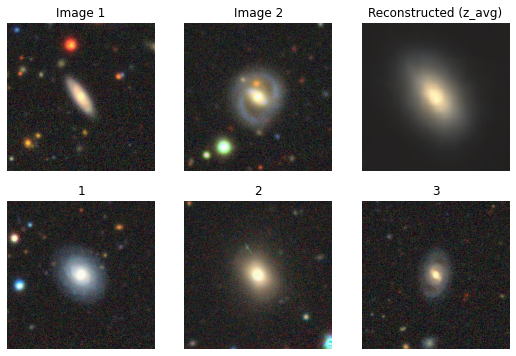

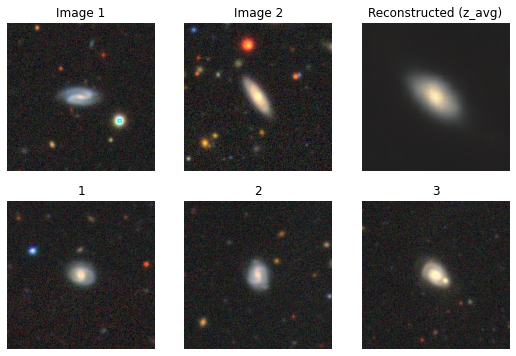

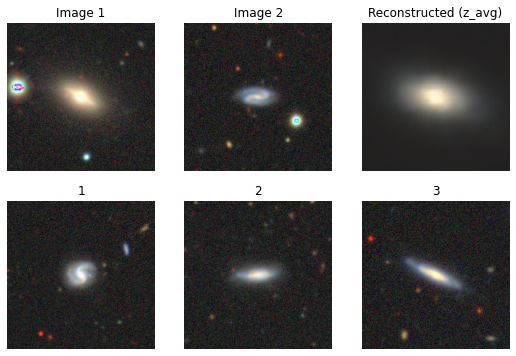

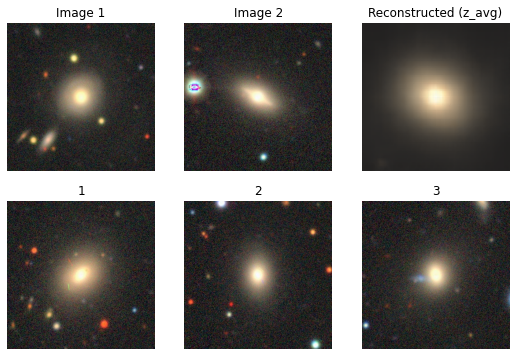

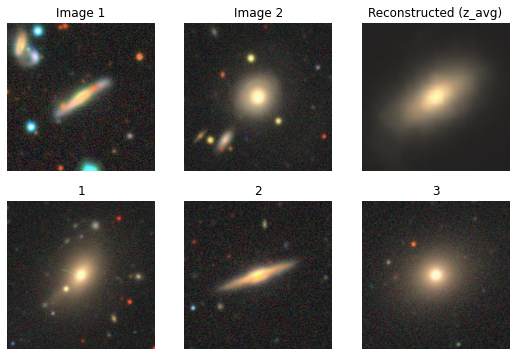

In [20]:
IMAGE_PATHS = glob.glob("/home/amax/ljm/DATA/Desi_galaxyzoo2_fits/DATA/DATAdesi/jpg/1/*.jpg")
if len(IMAGE_PATHS) < 2:
    raise ValueError("Need at least 2 images for interpolation.")
from scipy.spatial.distance import cdist
import torch

# 确保 latents 是 numpy array，device 正确
latents_np = latents  # shape (N, 128)，前面已提取
latents_tensor = torch.from_numpy(latents_np).to(device)

for i in range(1, 10):
    IMAGE_PATH_1 = IMAGE_PATHS[i+1]
    IMAGE_PATH_2 = IMAGE_PATHS[i]
    RESULT_PATH = f"./results/interpolated_recon_{i}.png"

    def load_and_encode(path):
        image = Image.open(path).convert('RGB')
        x = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            mu, log_var = model.encode(x)
            z = model.reparameterize(mu, log_var)
        return z, x, image  # 返回原始 PIL 图像用于显示

    # 编码两张图像
    z1, img1_tensor, img1_pil = load_and_encode(IMAGE_PATH_1)
    z2, img2_tensor, img2_pil = load_and_encode(IMAGE_PATH_2)

    # 插值：取均值
    z_avg = (z1 + z2) / 2  # shape: (1, 128)

    # 解码重建
    with torch.no_grad():
        recon_x = model.decode(z_avg).cpu()
        recon_img = transforms.ToPILImage()(recon_x[0].clamp(0, 1))

    # ---------------------------------------------
    # 🔍 在 latents 中找最接近 z_avg 的真实样本
    # ---------------------------------------------
    z_avg_np = z_avg.cpu().numpy().squeeze()  # shape: (128,)

    # 方法1：使用欧氏距离（推荐）

    distances = np.linalg.norm(latents_np - z_avg_np, axis=1)

    nearest_indices = np.argsort(distances)[:3]  # 获取距离最小的两个索引
    nearest_filenames = [filenames[idx] for idx in nearest_indices]  # 根据索引获取文件名

    nearest_pils = [Image.open(filename).convert('RGB') for filename in nearest_filenames]



    # ---------------------------------------------
    # 🖼️ 可视化：4张图
    # ---------------------------------------------
    plt.figure(figsize=(9, 6))

    # 原图1
    plt.subplot(2, 3, 1)
    plt.imshow(img1_pil)
    plt.title("Image 1")
    plt.axis("off")

    # 原图2
    plt.subplot(2, 3, 2)
    plt.imshow(img2_pil)
    plt.title("Image 2")
    plt.axis("off")

    # 重建的插值图像
    plt.subplot(2, 3, 3)
    plt.imshow(recon_img)
    plt.title("Reconstructed (z_avg)")
    plt.axis("off")

    # 最相似的真实图像
    count = 0
    for nearest_pil in nearest_pils:

        count += 1
        plt.subplot(2, 3, count+3)
        plt.imshow(nearest_pil)
        plt.title(f"{count}")
        plt.axis("off")

    # 保存并显示
    os.makedirs("./results", exist_ok=True)

    plt.show()



tensor(3.1546, device='cuda:0') tensor(-2.8786, device='cuda:0') tensor(-0.2160, device='cuda:0')


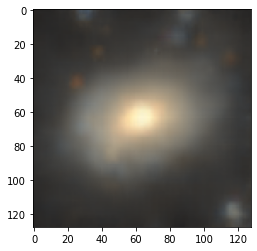

In [23]:
z_avg = torch.randn(1, 128).to(device)*1    # 均值为0，标准差为1
print(z_avg.max(),z_avg.min(),z_avg.mean())
with torch.no_grad():
    recon_x = model.decode(z_avg).cpu()
    recon_img = transforms.ToPILImage()(recon_x[0].clamp(0, 1))

plt.imshow(recon_img)
plt.show()


In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# -------------------------------
# 参数设置
# -------------------------------
NUM_SAMPLES = 100
LATENT_DIM = 128
IMG_SIZE = 128  # 根据你的模型调整
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 解码器输出是 [B, C, H, W]，假设 C=3, H=W=128
transform_pil = transforms.ToPILImage()

# 确保模型在 eval 模式
model.eval()

# -------------------------------
# 步骤1：生成 100 个随机隐向量并解码
# -------------------------------
z_list = []
recon_tensors = []

with torch.no_grad():
    for i in range(NUM_SAMPLES):
        # 采样 z ~ N(0, 1)
        z = torch.randn(1, LATENT_DIM).to(device)
        z_list.append(z)

        # 解码
        recon = model.decode(z)                    # shape: (1, 3, 128, 128)
        recon_clamped = recon.clamp(0, 1)          # 限制到 [0,1]
        recon_tensors.append(recon_clamped.cpu())

# 拼接成一个大张量: (100, 3, 128, 128)
all_recons = torch.cat(recon_tensors, dim=0)  # shape: [100, 3, H, W]

print(f"✅ Generated {NUM_SAMPLES} samples. Shape: {all_recons.shape}")

✅ Generated 100 samples. Shape: torch.Size([100, 3, 128, 128])


(-0.5, 127.5, 127.5, -0.5)

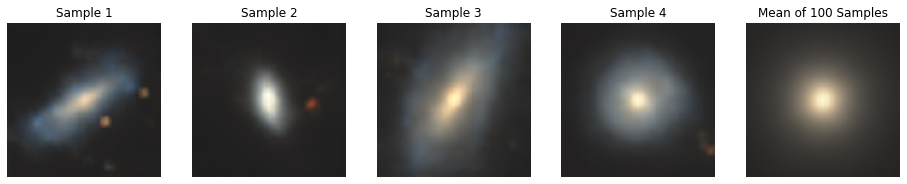

In [44]:
# 转为 numpy，方便处理
all_recons_np = all_recons.numpy()  # (100, 3, H, W)

# 计算均值图和标准差图（在 batch 维度上）
mean_img = all_recons_np.mean(axis=0)    # (3, H, W)
std_img  = all_recons_np.std(axis=0)     # (3, H, W)

# 转换为可显示格式 (H, W, 3)
mean_img_hwc = np.transpose(mean_img, (1, 2, 0))
std_img_hwc  = np.transpose(std_img,  (1, 2, 0))

# -------------------------------
# 可视化：均值、标准差、示例图像
# -------------------------------
fig, axes = plt.subplots(1, 5, figsize=(16, 8))

# 原始样本示例（前4张）
for i in range(4):
    img = np.transpose(all_recons_np[i], (1, 2, 0))
    axes[i].imshow(img)
    axes[i].set_title(f"Sample {i+1}")
    axes[i].axis('off')

# 均值图像
axes[4].imshow(mean_img_hwc)
axes[4].set_title("Mean of 100 Samples")
axes[4].axis('off')


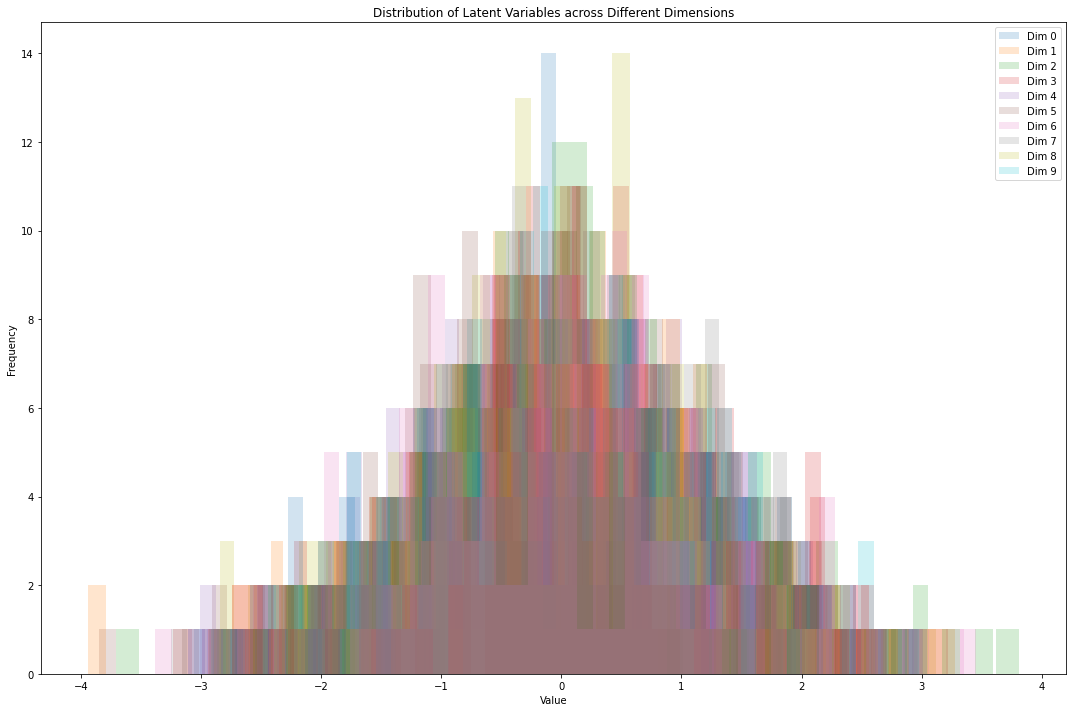

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for i in range(128): 
    a = [per[0, i].item() for per in z_list]  # 使用 .item() 获取单个数值
    plt.hist(a, bins=40, alpha=0.2, label=f'Dim {i}' if i < 10 else None)  # 仅前10个维度加标签避免过于杂乱
  
plt.legend()
plt.title('Distribution of Latent Variables across Different Dimensions')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()